### Ideal Land formula

In [203]:
def neededLands(avg_mana_value, ramp_number):
    '''Formula per calcolare le terre necessarie considerando il costo di mana medio e
    il numero di ramp economici (valore di mana 3 o minore)'''
    return (31.42 + 3.13*avg_mana_value - 0.28*ramp_number)

neededLands(3.87, 17)

38.77310000000001

### Ramp calculator

In [172]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def sampleAndRemove(deck, num):
    cards = random.sample(deck, num)
    for card in cards:
        deck.remove(card)
    return cards, deck

def createDeck(lands, ramp):
    decks = []
    for i in range(lands):
        decks.append('land' + str(i))
    for r in ramp:
        for q in range(r['quantity']):
            r['id'] = str(q)
            
            decks.append(r)
    for i in range(99 - len(decks)):
        decks.append('other' + str(i))
    return decks

def getLand(hands):
    return  [h for h in hands if isinstance(h, str) and  h.startswith('land')]

def getRamp(hands, mana_value):
    ramps = [h for h in hands if isinstance(h, dict) and  h['mv'] <= mana_value ]
    sorted_ramps = sorted(ramps, key=lambda x: x['ramp'], reverse=True)
    return sorted_ramps

def getPlot(dati):
    frequenze = dict(sorted(Counter(dati).items()))
    totale_elementi = sum(frequenze.values())
    # Calcola le percentuali
    percentuali = {k: (v / totale_elementi) * 100 for k, v in frequenze.items()}
    # Prepara i dati per il plotting
    labels, values = zip(*percentuali.items())
    # Calcola le percentuali cumulative
    percentuali_cumulative = np.cumsum(values)
    
    # Crea l'istogramma
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    color = 'tab:blue'
    ax1.bar(labels, values, width=0.5, align='center', color=color)
    ax1.set_xlabel('Turno')
    ax1.set_ylabel('Percentuale (%)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Aggiungi i valori delle percentuali sopra le barre
    for i, v in enumerate(values):
        ax1.text(labels[i], v + 0.5, f"{v:.2f}%", ha='center', color=color)
    
    # Crea un secondo asse per la percentuale cumulata
    ax2 = ax1.twinx()
    
    color = 'tab:red'
    ax2.plot(labels, percentuali_cumulative, color=color, marker='o', linestyle='-', linewidth=2, label='Cumulativo (%)')
    ax2.set_ylabel('Cumulativo (%)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Aggiungi i valori delle percentuali cumulative
    for i, v in enumerate(percentuali_cumulative):
        ax2.text(labels[i], v, f"{v:.2f}%", ha='center', color=color)
    
    # Aggiungi una legenda
    fig.tight_layout()
    plt.title('Probabilità di raggiungere il target al turno n-esimo')
    plt.show()
    return percentuali_cumulative, labels

def runMatch(target, lands, ramp, min_ramp, min_land, max_mulligans):
    deck = createDeck(lands, ramp)
    mana_value = 0
    reached_target = False
    turn = 0

    ### mano iniziale
    hands, deck = sampleAndRemove(deck, 7)
    avg_lands_in_init_hand = len(getLand(hands))
    ramp_in_init_hand = len(getRamp(hands, 3))

    hand_is_ok = False

    remove = 0
    
    while(hand_is_ok == False):
        
        if (avg_lands_in_init_hand < min_land or ramp_in_init_hand < min_ramp) and  remove < max_mulligans:
            ### mulligan
            deck = createDeck(lands, ramp)
            hands, deck = sampleAndRemove(deck, 7 - remove)
            avg_lands_in_init_hand = len(getLand(hands))
            ramp_in_init_hand = len(getRamp(hands, 3))
            remove += 1
        else:
            hand_is_ok = True
        

    while(reached_target == False):
        #### numero di turno
        turn += 1
        ### pesca
        draw, deck = sampleAndRemove(deck, 1)
        hands += draw

        ### gioca terra se c'è
        land_in_hands = getLand(hands)
        if len(land_in_hands) > 0:
            hands.remove(land_in_hands[0])
            mana_value += 1

        if mana_value >= target:
            return turn, avg_lands_in_init_hand

        ### gioca ramp se c'è
        getAvailableRamp = getRamp(hands, mana_value)
        if len(getAvailableRamp):
            used_ramp = getAvailableRamp[0]
            hands.remove(used_ramp)
            mana_value += used_ramp['ramp']

def calculateDropPerTurn(target , lands , ramp ,  min_ramp = 1, min_land = 3, max_mulligans = 2, simulation = 1000):
    results = {'lands_init_hand' : [], 'turn_reached' : []}
    for s in range(simulation):
        turn, land_init = runMatch(target, lands, ramp, min_ramp, min_land, max_mulligans)
        results['lands_init_hand'].append(land_init)
        results['turn_reached'].append(turn)
    turns = results['turn_reached']
    perc_cumulative, labels = getPlot(turns)
    df = pd.DataFrame({'turno' : labels, 'percentuale cumulativa di successo' : perc_cumulative})
    return df
    

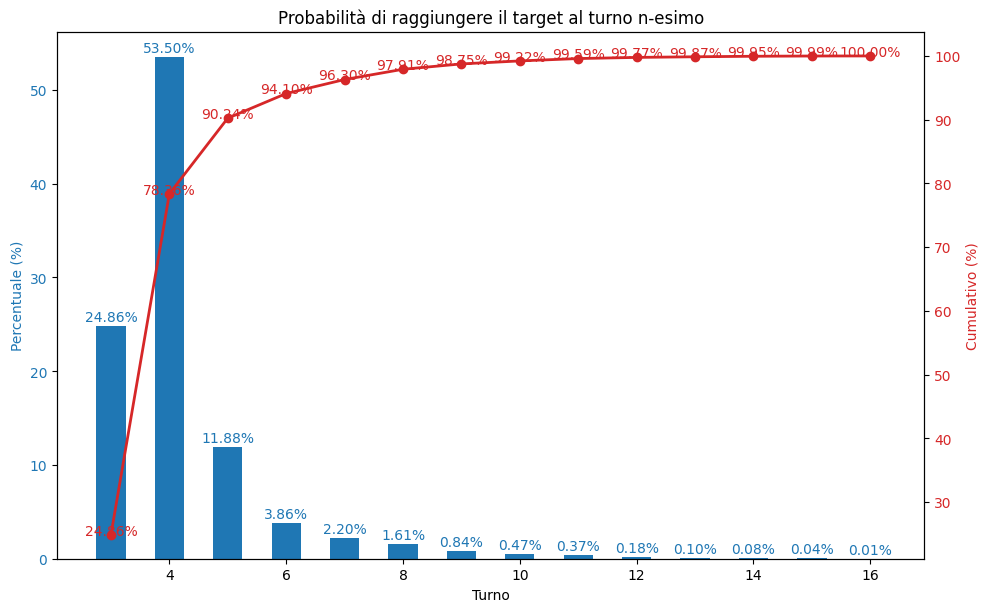

,turno,percentuale cumulativa di successo
0,3,24.86
1,4,78.36
2,5,90.24
3,6,94.10
4,7,96.30
5,8,97.91
6,9,98.75
7,10,99.22
8,11,99.59
9,12,99.77


In [200]:

RAMP = [
    {
        "mv" : 1, ####### esempio di sol ring
        "quantity" : 1,
        "ramp" : 2
    },
    {
        "mv" : 1,  ###### uccelli del paradiso
        "quantity" : 4,
        "ramp" : 1
    },
    {
        "mv" : 2, ###### farseek
        "quantity" : 8,
        "ramp" : 1
    },
    {
        "mv" : 3, ##### cultivate
        "quantity" : 2,
        "ramp" : 1
    },
    {
        "mv" : 3, ### urza incubator
        "quantity" : 1,
        "ramp" : 2
    }
]

LANDS = 37 ######## IL NUMERO DI TERRE NEL TUO MAZZO

TARGET = 5 ######## IL TARGET DEL TUO MAZZO, AD ESEMPIO IL VALORE TARGET


calculateDropPerTurn(TARGET, LANDS, RAMP,  min_ramp = 1, min_land = 3, max_mulligans = 1, simulation=10000)